In [1]:
## COMP9517 Computer Vision Project 20T2
# code: Main program for the project
#
# Group C:
# Connor Baginski (z5207788)
# Bhumika Singhal (z5234799)
# Rishav Guha (z5294757)
# Amel Johny (z5294308)


# from cell_tracking.kalmanFilter import KalmanFilter
# from scipy.optimize import linear_sum_assignment
# # from cell_tracking.tracking_objects  import Tracker 
# from cell_tracking.tracking_objects  import Track 
from cell_tracking.helpers import fi_list, find_centers, plot_rectangles,draw_path,find_labels_Phc,find_labels_Fluo
from cell_tracking.pathTracking import PathTracker

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
import imutils

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from skimage.morphology import watershed, disk
from skimage.feature import peak_local_max
from skimage.filters import meijering

from scipy import ndimage as ndi


def fi_list(path):
    """
    Return a sorted list of filenames in a given path
    """
    return sorted([os.path.join(path, f) for f in os.listdir(path)])

def custom_thresh(image):
    for r in range(image.shape[0]):
        for c in range(image.shape[1]):
            if image[r,c] > 0.05:
                image[r,c] = 255
            else:
                image[r,c] = 0

    return image

def disk_erode(img, radius=24, iters=1):
    image = img.copy()
    kern_disk = disk(radius)
    eroded = cv2.erode(image, kern_disk, iterations=iters)
    
    return eroded


In [2]:
def detect_DIC():
    for filename in fi_list('DIC-C2DH-HeLa/Sequence 1 Masks'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        plt.title("Ground Truth")
        plt.imshow(image)
        plt.show()
        
        cell_mask = (image > 0).astype(np.uint8)
        plt.imshow(cell_mask)
        plt.show()
        
        markers = disk_erode(cell_mask)
        plt.title("Markers")
        plt.imshow(markers)
        plt.show()
        """
        blurred = cv2.medianBlur(image, 21)
        
        denoised = cv2.fastNlMeansDenoising(blurred, h=3)        
        
        # adaptive normalization - see paper https://is.muni.cz/www/svoboda/ISBI-final.pdf
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl1 = clahe.apply(denoised)
        
        mj_filtered = meijering(cl1)
        mj_filtered = custom_thresh(mj_filtered)
        
        kernel = np.ones((4,4),np.uint8)

        eroded = cv2.erode(mj_filtered, kernel, iterations=1)

        thresh = cv2.threshold(eroded, 129, 255, cv2.THRESH_BINARY)[1]

        distance = ndi.distance_transform_edt(thresh)
        local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)),
                                labels=thresh)
        markers, _ = ndi.label(local_maxi)
        ws_labels = watershed(-distance, markers, mask=thresh)
        
        plt.gray()
        plt.imshow(image)
        plt.show()
        
        plt.imshow(blurred)
        plt.show()
        
        plt.imshow(denoised)
        plt.show()
        
        plt.imshow(cl1)
        plt.show()
        
        plt.imshow(mj_filtered)
        plt.show()
        
        plt.imshow(eroded)
        plt.show()
        
        plt.imshow(thresh, cmap='gray')
        plt.show()
        
        plt.imshow(ws_labels)
        plt.show()
        
        #break stops loop after one iteration for debugging
        break
        """
    return

In [3]:
def detect_Fluo():
    #initialising Object for tracking
    pathTracker_Fluo = PathTracker() 
    for filename in fi_list('Fluo-N2DL-HeLa/Sequence 1'):
        if not filename.endswith(".tif"):
            continue
        # print(filename)
        ws_lables,image = find_labels_Fluo(filename)
        #Extract the centers of cells detected
        centers, boundingBoxes = find_centers(ws_lables,image)
        # print(len(boundingBoxes))
        #draw bounding boxes for the detected cells
        plot_rectangles(image, centers, boundingBoxes)

        pathTracker_Fluo.update(image,centers)        
        # #TODO: cite/recode following
        # # loop over the unique labels returned by the Watershed
        # # algorithm
        # centers = []
        # for label in np.unique(ws_labels):
        #     # if the label is zero, we are examining the 'background'
        #     # so simply ignore it
        #     if label == 0:
        #         continue

        #     # otherwise, allocate memory for the label region and draw
        #     # it on the mask
        #     mask = np.zeros(image.shape, dtype="uint8")
        #     mask[ws_labels == label] = 255

        #     # detect contours in the mask and grab the largest one
        #     cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        #         cv2.CHAIN_APPROX_SIMPLE)
        #     cnts = imutils.grab_contours(cnts)
        #     c = max(cnts, key=cv2.contourArea)

        #     # draw a rectangle enclosing the object
        #     try:
        #         x,y,w,h = cv2.boundingRect(c)
        #         center = np.array([[int(x + w / 2.0)], [int(y + h / 2.0)]])
        #         centers.append(center)
        #         # print(bounding_box_center)
                
        #     except ZeroDivisionError:
        #         pass
        #     cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
        #     cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
        #         cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        # image = track_path(image,centers,trackIdCount,tracker)
        # # plt.gray()
        # # plt.imshow(thresh, cmap='gray')
        # # plt.show()
        # plt.imshow(image)
        # plt.show()
    return



In [4]:

def detect_PhC():
    pathTracker = PathTracker()
    for filename in fi_list('PhC-C2DL-PSC/Sequence 1'):
        if not filename.endswith(".tif"):
            continue
        #process images to segment the cells to find labels
        ws_lables,image = find_labels_Phc(filename)
        #Extract the centers of cells detected
        centers, boundingBoxes = find_centers(ws_lables,image)
        #draw bounding boxes for the detected cells
        plot_rectangles(image, centers, boundingBoxes)
                    
        pathTracker.update(image,centers)
#         plt.imshow(opening, cmap='gray')
#         plt.show()
        # plt.imshow(ws_labels, cmap='gray')
        # plt.show()
    return

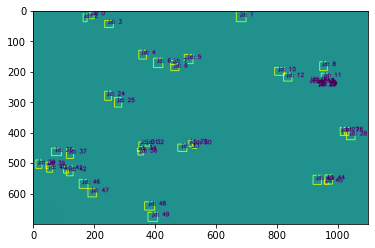

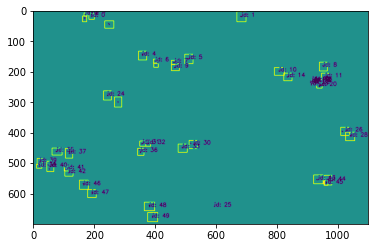

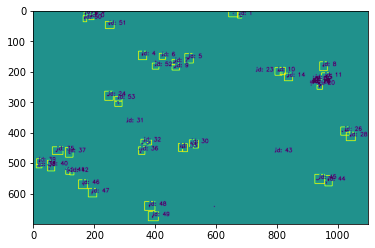

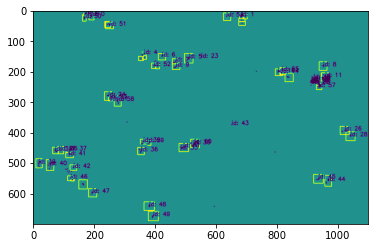

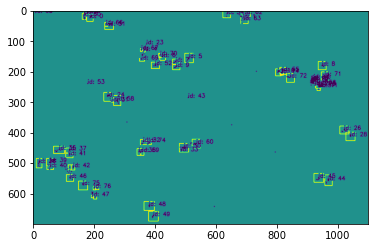

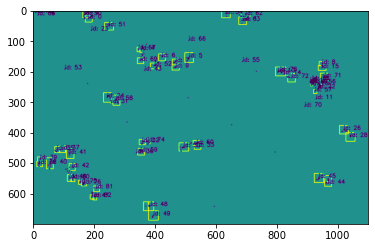

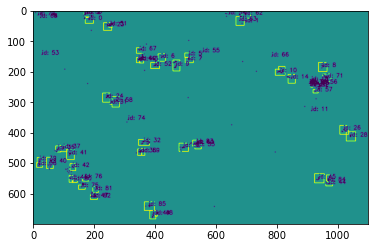

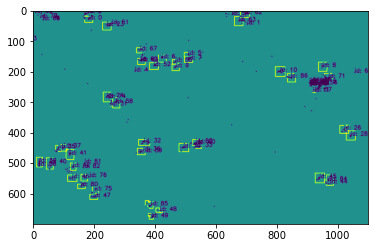

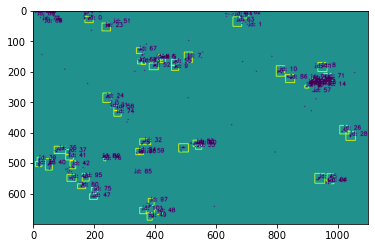

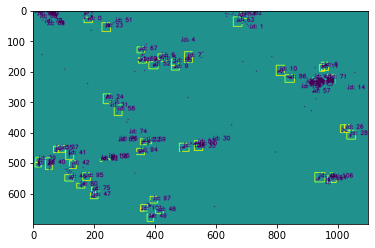

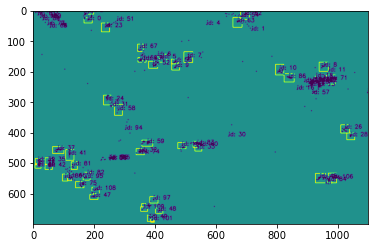

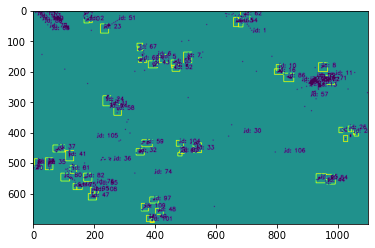

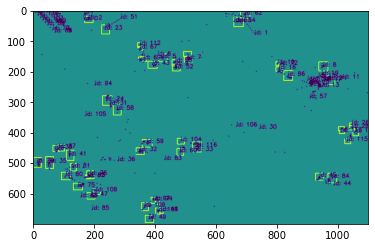

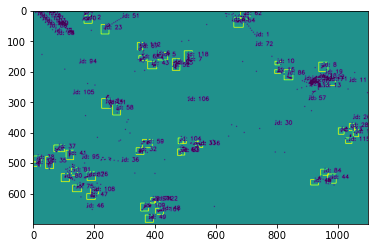

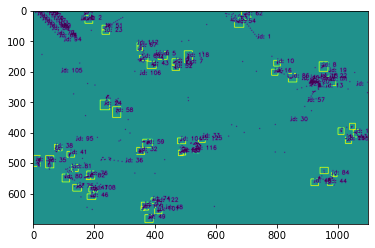

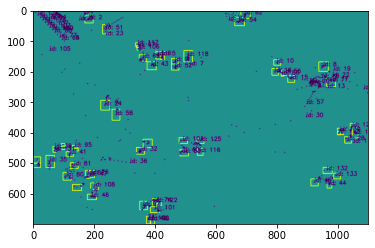

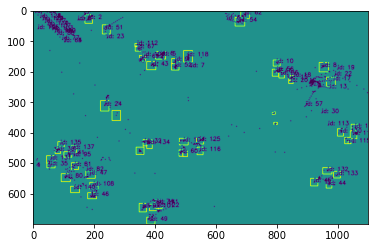

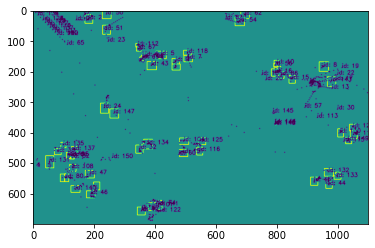

IndexError: list assignment index out of range

In [5]:
def main():
    select = int(input("Choose a dataset.\n1) DIC-C2DH-HeLa\n2) Fluo-N2DL-HeLa\n3) PhC-C2DL-PSC\n> "))
    # select = 3 ##FOR TESTING

    if select == 1:
        detect_DIC()
    elif select == 2:
        detect_Fluo()
    elif select == 3:
        detect_PhC()
    else:
        print("Invalid input.")

if __name__ == '__main__':
    main()